In [90]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Evaluation of Nanopore-base drug resistance prediction

This notebook contains the figures and tables for the drug resistance prediction component of our paper *Nanopore sequencing for _Mycobacterium tuberculosis_ public health applications*

In [2]:
import pandas as pd
from pathlib import Path
from typing import Tuple
from itertools import product
from collections import defaultdict
import pandas as pd
import numpy as np
from enum import Enum
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

phenosheet = "../../../../docs/phenotypes.csv"
plt.style.use("ggplot")

<IPython.core.display.Javascript object>

Load the concordance data. This gives us the mykrobe Illumina and Nanopore calls for each sample-drug combination.

In [3]:
coverages = np.arange(start=25, stop=155, step=5)

<IPython.core.display.Javascript object>

In [4]:
covdf = pd.read_csv("coverage.csv", index_col="sample")

<IPython.core.display.Javascript object>

In [5]:
concordance_files = list(
    Path("../../results/concordance/mykrobe/nanopore").rglob("*.csv")
)

<IPython.core.display.Javascript object>

In [6]:
frames = []
for p in concordance_files:
    sample, tool = p.name.split(".")[0:2]
    table = pd.read_csv(p)
    table["sample"] = sample
    table["tool"] = tool
    table.rename(
        columns={"true_call": "Illumina", "test_call": "Nanopore"}, inplace=True
    )
    frames.append(table)

<IPython.core.display.Javascript object>

In [7]:
calls = pd.concat(frames)
calls.reset_index(drop=True, inplace=True)
valid_samples = set(calls["sample"])

<IPython.core.display.Javascript object>

In [8]:
calls

,drug,classification,Illumina,Nanopore,sample,tool
0,Ofloxacin,TN,S,S,18_620606,mykrobe
1,Moxifloxacin,TN,S,S,18_620606,mykrobe
2,Isoniazid,TN,S,S,18_620606,mykrobe
3,Kanamycin,TN,S,S,18_620606,mykrobe
4,Ethambutol,TN,S,S,18_620606,mykrobe
...,...,...,...,...,...,...
1645,Ciprofloxacin,TP,R,R,R27937,mykrobe
1646,Pyrazinamide,TP,R,R,R27937,mykrobe
1647,Rifampicin,TP,R,R,R27937,mykrobe
1648,Amikacin,FP,S,R,R27937,mykrobe


<IPython.core.display.Javascript object>

Load the phenotype information

In [9]:
pheno = pd.read_csv(phenosheet).melt(
    id_vars=["sample"], var_name="drug", value_name="phenotype"
)
arr = []
for r in pheno["phenotype"]:
    if pd.isna(r):
        arr.append(r)
    elif r.upper() in ("R", "S"):
        arr.append(r.upper())
    else:
        arr.append(None)
pheno["phenotype"] = arr
pheno = pheno.loc[pheno["sample"].isin(valid_samples)]
pheno.set_index(["sample", "drug"], drop=False, inplace=True)

<IPython.core.display.Javascript object>

In [10]:
pheno

sample          drug phenotype
sample   drug                                          
mada_102 streptomycin  mada_102  streptomycin         S
mada_103 streptomycin  mada_103  streptomycin         S
mada_104 streptomycin  mada_104  streptomycin         S
mada_105 streptomycin  mada_105  streptomycin         S
mada_106 streptomycin  mada_106  streptomycin         S
...                         ...           ...       ...
R31095   ethionamide     R31095   ethionamide       NaN
         ethionamide     R31095   ethionamide       NaN
R32929   ethionamide     R32929   ethionamide       NaN
R36431   ethionamide     R36431   ethionamide         R
R37765   ethionamide     R37765   ethionamide       NaN

[2860 rows x 3 columns]

<IPython.core.display.Javascript object>

In [11]:
mykrobe_drugs = set(calls["drug"])

<IPython.core.display.Javascript object>

In [12]:
d = {}
for drug in map(str.lower, mykrobe_drugs):
    d[drug.upper()] = list(pheno.query("drug == @drug").dropna()["sample"])
#     lpa = drug + "-lpa"
#     d[lpa.upper()] = list(pheno.query("drug == @lpa").dropna()["sample"])

<IPython.core.display.Javascript object>

In [13]:
upset_data = upsetplot.from_contents(d)

<IPython.core.display.Javascript object>

## Figure 1
Culture-based drug susceptibility data available for samples. Each row is a drug, and the columns represent a set of samples that have phenotype information for those drugs with a filled cell. The top panel shows the number of samples in the set for that combination of drugs. The bar plot in the left panel shows the number of samples with phenotype information for that drug.

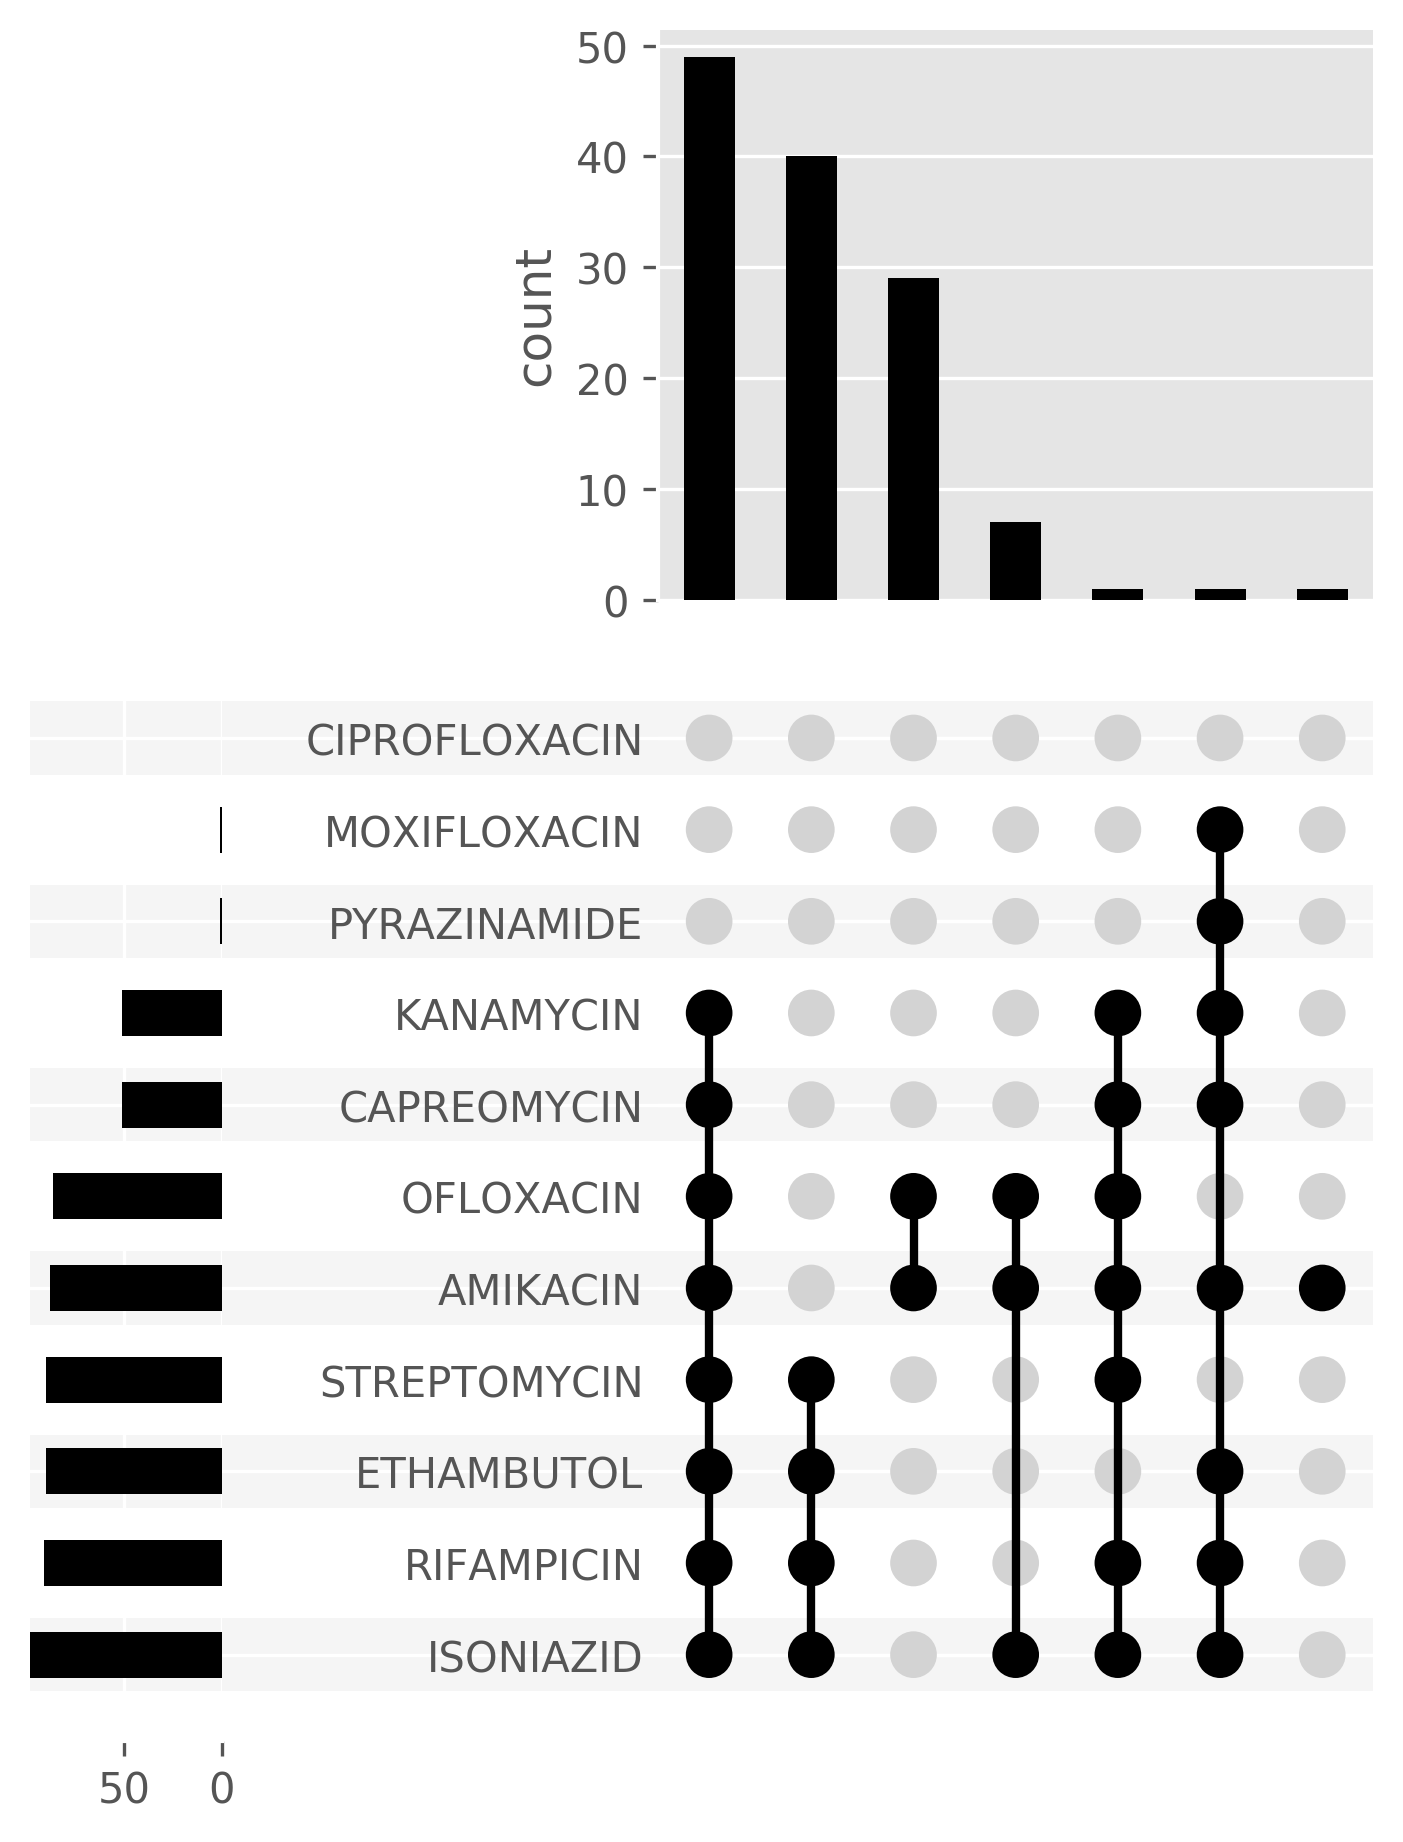

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots()
p = upsetplot.plot(
    upset_data,
    fig=fig,
    sort_by="cardinality",
    orientation="horizontal",
)
p["intersections"].set_ylabel("count")
ax.axis("off")
# fig.set_figwidth(8)
# fig.set_figheight(10)
fig.set_dpi(300)

## Resistance prediction performance of mykrobe
mykrobe has been rigorously evaluated on datasets which much better/broader phenotype availability. However, it's prediction ability on ONT data has only been validated with 5 samples. We look to validate it's performance on this dataset's Illumina and ONT data, for those drugs/samples where phenotype data is available. 
We will also discuss the causes for any discrepencies and look to COMPASS/bcftools calls for adjudication if possible.

The figure for this section will basically be a copy of [5c/d from the mykrobe nature comms paper](https://www.nature.com/articles/ncomms10063#Fig5) (side-by-side bar charts showing resistant/susceptible samples, with stacked bars indicating FPs and FNs)

In [125]:
# taken from https://apps.who.int/iris/bitstream/handle/10665/130918/9789241548809_eng.pdf?sequence=1&isAllowed=y
drug_abbrev = {
    "ethambutol": "E",
    "isoniazid": "H",
    "pyrazinamide": "Z",
    "rifampicin": "R",
    "streptomycin": "S",
    "kanamycin": "Km",
    "amikacin": "Am",
    "ofloxacin": "Ofx",
    "capreomycin": "Cm",
    "moxifloxacin": "Mfx",
    "ciprofloxacin": "Cfx",
}


class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"
    Unknown = "U"
    Failed = "F"

    def __str__(self) -> str:
        return self.value


class Classifier(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value

    @staticmethod
    def from_predictions(y_true: Prediction, y_pred: Prediction) -> "Classifier":
        if y_true is Prediction.Susceptible:
            return (
                Classifier.TrueNegative
                if y_pred is Prediction.Susceptible
                else Classifier.FalsePositive
            )
        elif y_true is Prediction.Resistant:
            return (
                Classifier.TruePositive
                if y_pred in (Prediction.Resistant, Prediction.MinorResistance)
                else Classifier.FalseNegative
            )
        else:
            raise NotImplementedError(
                "Don't know how to classify minor resistant calls yet"
            )


@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def ppv(self) -> float:
        """Also known as precision"""
        try:
            return self.tp / (self.tp + self.fp)
        except ZeroDivisionError:
            return None

    def npv(self) -> float:
        """Negative predictive value"""
        try:
            return self.tn / (self.tn + self.fn)
        except ZeroDivisionError:
            return None

    def sensitivity(self) -> float:
        """Also known as recall and true positive rate (TPR)"""
        try:
            return self.tp / (self.tp + self.fn)
        except ZeroDivisionError:
            return None

    def specificity(self) -> float:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            return self.tn / (self.tn + self.fp)
        except ZeroDivisionError:
            return None

    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.recall()
        if ppv is None or tpr is None:
            return None
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))

<IPython.core.display.Javascript object>

In [16]:
pheno_clf = []
for ix, row in calls.iterrows():
    ill_pred = Prediction(row["Illumina"])
    ont_pred = Prediction(row["Nanopore"])
    drug = row["drug"].lower()
    sample = row["sample"]
    try:
        ph = pheno.loc[(sample, drug), "phenotype"]
        if pd.isna(ph).all():
            continue
        else:
            truth = Prediction(ph[0])
    except KeyError:
        continue
    ill_clf = Classifier.from_predictions(truth, ill_pred)
    ill_covg = covdf.loc[sample]["illumina_covg"]
    pheno_clf.append((sample, drug, str(ill_clf), "illumina", ill_covg))
    ont_clf = Classifier.from_predictions(truth, ont_pred)
    ont_covg = covdf.loc[sample]["nanopore_covg"]
    pheno_clf.append((sample, drug, str(ont_clf), "nanopore", ont_covg))

/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


<IPython.core.display.Javascript object>

In [17]:
clf_df = pd.DataFrame(
    pheno_clf, columns=["sample", "drug", "classification", "technology", "coverage"]
)

<IPython.core.display.Javascript object>

In [18]:
pheno_cms = defaultdict(dict)

for drug, tech in product(set(clf_df["drug"]), set(clf_df["technology"])):
    s = clf_df.query("drug == @drug and technology == @tech").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    pheno_cms[drug][tech] = cm

<IPython.core.display.Javascript object>

In [19]:
metrics = []
for drug, technology in pheno_cms.items():
    for tech, cm in technology.items():
        sensitivity = cm.sensitivity()
        specificity = cm.specificity()
        ppv = cm.ppv()
        npv = cm.npv()
        metrics.append((drug, tech, sensitivity, specificity, ppv, npv))

summary = pd.DataFrame(
    metrics, columns=["drug", "tech", "sensitivity", "specificity", "PPV", "NPV"]
).melt(id_vars=["drug", "tech"], var_name="metric")

<IPython.core.display.Javascript object>

## Figure 2
Number of resistant (left) and susceptible (right) phenotypes correctly identified by mykrobe from Illumina (blue) and Nanopore (purple) data from the same samples. The red bars indicate missed (FN) or incorrect (FP) predictions. The x-axis shows the drugs with available phenotype data that mykrobe also makes predictions for. E - ethambutol; H - isoniazid; Z - pyrazinamide; R - rifampicin; S - streptomycin; Km - kanamycin; Am - amikacin; Ofx - ofloxacin; Cm - capreomycin; Mfx - moxifloxacin.

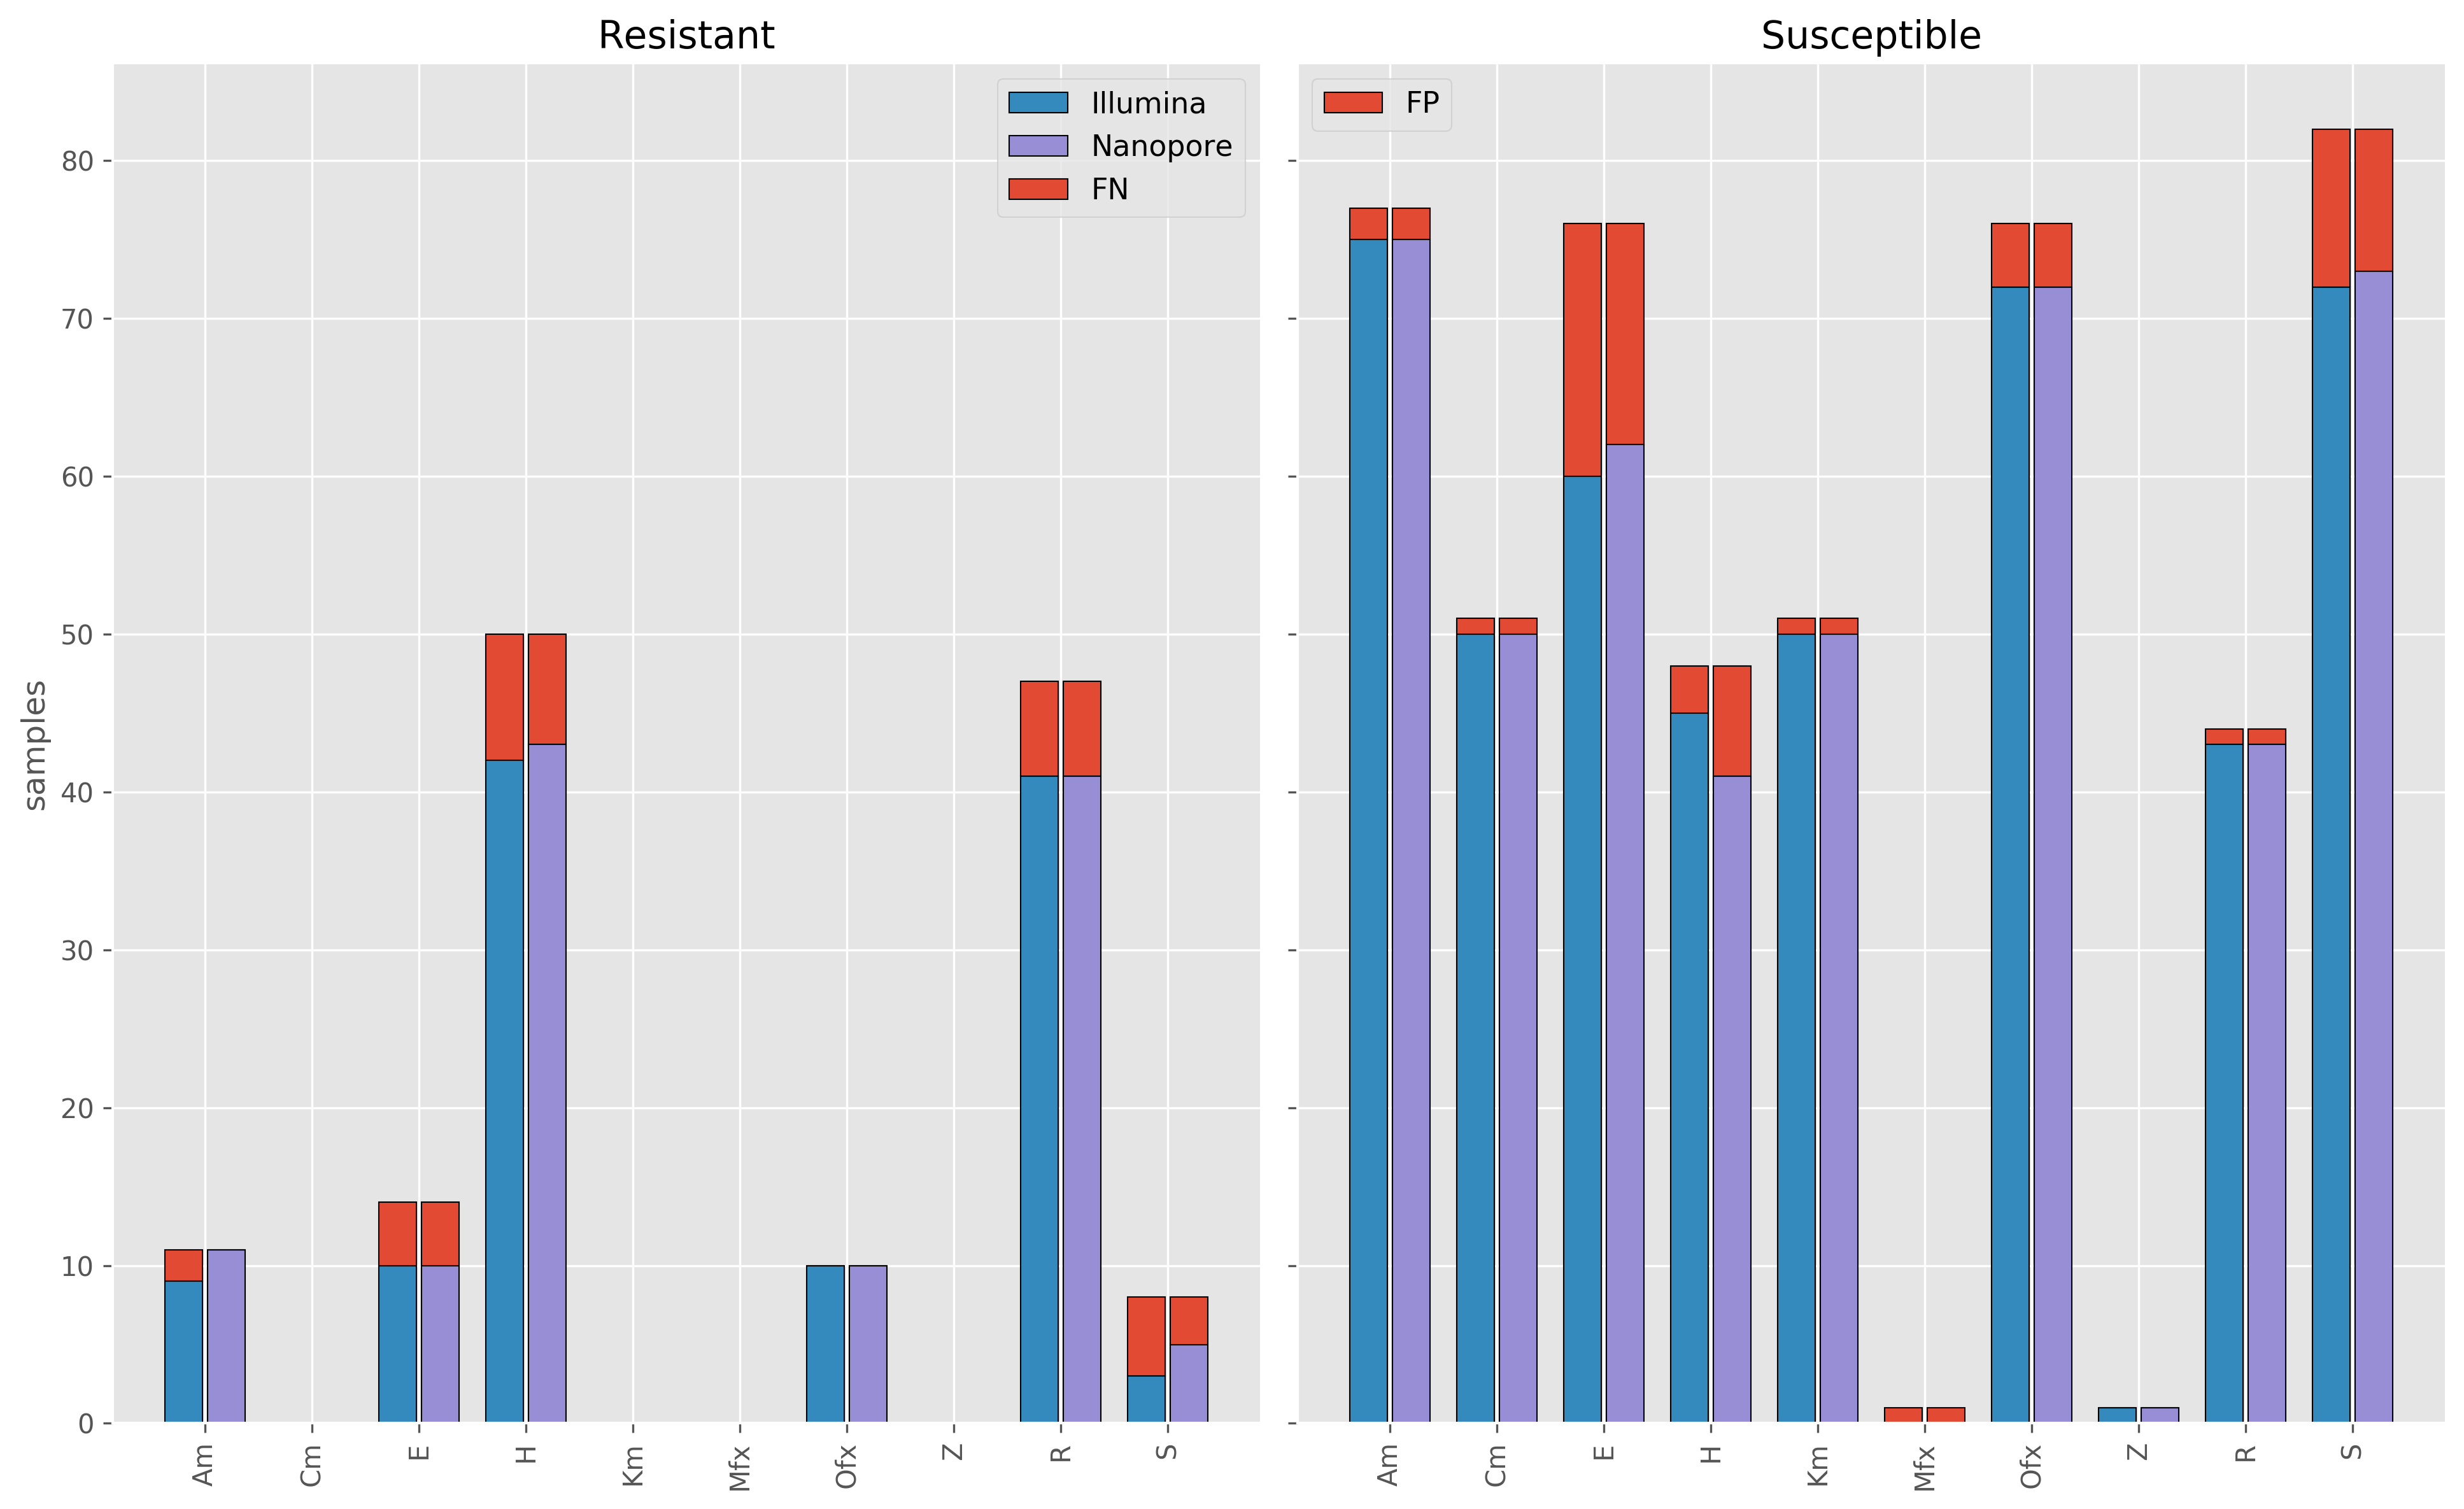

<IPython.core.display.Javascript object>

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]
# make up some fake data
drugs = sorted(pheno_cms.keys())
ill_tps = [pheno_cms[d]["illumina"].tp for d in drugs]
ill_fns = [pheno_cms[d]["illumina"].fn for d in drugs]
ill_tns = [pheno_cms[d]["illumina"].tn for d in drugs]
ill_fps = [pheno_cms[d]["illumina"].fp for d in drugs]
ont_tps = [pheno_cms[d]["nanopore"].tp for d in drugs]
ont_fns = [pheno_cms[d]["nanopore"].fn for d in drugs]
ont_tns = [pheno_cms[d]["nanopore"].tn for d in drugs]
ont_fps = [pheno_cms[d]["nanopore"].fp for d in drugs]

ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
red = ggplot_cm[0]
blue = ggplot_cm[1]
purple = ggplot_cm[2]
edgecol = "black"

# plot details
bar_width = 0.35
epsilon = 0.05
line_width = 0.5
alpha = 1.0
ill_positions = np.arange(len(ill_tps))
ont_positions = ill_positions + bar_width + epsilon

# resistance bar plots
ill_tps_bar = axR.bar(
    ill_positions,
    ill_tps,
    bar_width,
    color=blue,
    edgecolor=edgecol,
    linewidth=line_width,
    label="Illumina",
)
ill_fns_bar = axR.bar(
    ill_positions,
    ill_fns,
    bar_width,
    bottom=ill_tps,
    color=red,
    edgecolor=edgecol,
    linewidth=line_width,
)

ont_tps_bar = axR.bar(
    ont_positions,
    ont_tps,
    bar_width,
    color=purple,
    edgecolor=edgecol,
    linewidth=line_width,
    label="Nanopore",
)
ont_fns_bar = axR.bar(
    ont_positions,
    ont_fns,
    bar_width,
    bottom=ont_tps,
    color=red,
    edgecolor=edgecol,
    linewidth=line_width,
    label="FN",
)

# susceptible bar plots
ill_tns_bar = axS.bar(
    ill_positions,
    ill_tns,
    bar_width,
    color=blue,
    edgecolor=edgecol,
    linewidth=line_width,
)
ill_fps_bar = axS.bar(
    ill_positions,
    ill_fps,
    bar_width,
    bottom=ill_tns,
    color=red,
    edgecolor=edgecol,
    linewidth=line_width,
)
ont_tns_bar = axS.bar(
    ont_positions,
    ont_tns,
    bar_width,
    color=purple,
    edgecolor=edgecol,
    linewidth=line_width,
)
ont_fps_bar = axS.bar(
    ont_positions,
    ont_fps,
    bar_width,
    bottom=ont_tns,
    color=red,
    edgecolor=edgecol,
    linewidth=line_width,
    label="FP",
)

labels = [drug_abbrev[d] for d in drugs]
label_pos = [(x + y) / 2 for x, y in zip(ill_positions, ont_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
# leghandles.insert(2, leghandles[1])
# leglabels.insert(2, "TPs")
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})
sns.despine()
plt.tight_layout()

In [21]:
counts = clf_df.groupby(["drug", "technology", "classification"])["sample"].count()
drugs = sorted(set(clf_df["drug"]))
technologies = ["illumina", "nanopore"]
fps = [
    counts[d, t, "FP"] if (d, t, "FP") in counts else 0
    for d, t in product(drugs, technologies)
]
fns = [
    counts[d, t, "FN"] if (d, t, "FN") in counts else 0
    for d, t in product(drugs, technologies)
]
tns = [
    counts[d, t, "TN"] if (d, t, "TN") in counts else 0
    for d, t in product(drugs, technologies)
]
tps = [
    counts[d, t, "TP"] if (d, t, "TP") in counts else 0
    for d, t in product(drugs, technologies)
]
table = summary.set_index(["drug", "tech", "metric"])["value"].unstack().reset_index()
for k in ["drug", "tech"]:
    table[k] = table[k].str.capitalize()
table.rename(columns={"tech": "technology"}, inplace=True)
table["ME/FP"] = fps
table["VME/FN"] = fns
table["TP"] = tps
table["TN"] = tns
table.fillna("-", inplace=True)

<IPython.core.display.Javascript object>

This table summarises the results visualised above in Figure 2

In [22]:
table

metric,drug,technology,NPV,PPV,sensitivity,specificity,ME/FP,VME/FN,TP,TN
0,Amikacin,Illumina,0.974026,0.818182,0.818182,0.974026,2,2,9,75
1,Amikacin,Nanopore,1.0,0.846154,1.0,0.974026,2,0,11,75
2,Capreomycin,Illumina,1.0,0.0,-,0.980392,1,0,0,50
3,Capreomycin,Nanopore,1.0,0.0,-,0.980392,1,0,0,50
4,Ethambutol,Illumina,0.9375,0.384615,0.714286,0.789474,16,4,10,60
5,Ethambutol,Nanopore,0.939394,0.416667,0.714286,0.815789,14,4,10,62
6,Isoniazid,Illumina,0.849057,0.933333,0.84,0.937500,3,8,42,45
7,Isoniazid,Nanopore,0.854167,0.86,0.86,0.854167,7,7,43,41
8,Kanamycin,Illumina,1.0,0.0,-,0.980392,1,0,0,50
9,Kanamycin,Nanopore,1.0,0.0,-,0.980392,1,0,0,50


<IPython.core.display.Javascript object>

In [23]:
print(table.to_markdown(index=False))

| drug         | technology   | NPV                | PPV                 | sensitivity        |   specificity |   ME/FP |   VME/FN |   TP |   TN |
|:-------------|:-------------|:-------------------|:--------------------|:-------------------|--------------:|--------:|---------:|-----:|-----:|
| Amikacin     | Illumina     | 0.974025974025974  | 0.8181818181818182  | 0.8181818181818182 |      0.974026 |       2 |        2 |    9 |   75 |
| Amikacin     | Nanopore     | 1.0                | 0.8461538461538461  | 1.0                |      0.974026 |       2 |        0 |   11 |   75 |
| Capreomycin  | Illumina     | 1.0                | 0.0                 | -                  |      0.980392 |       1 |        0 |    0 |   50 |
| Capreomycin  | Nanopore     | 1.0                | 0.0                 | -                  |      0.980392 |       1 |        0 |    0 |   50 |
| Ethambutol   | Illumina     | 0.9375             | 0.38461538461538464 | 0.7142857142857143 |      0.789474 |      1

<IPython.core.display.Javascript object>

In [25]:
clf_df

,sample,drug,classification,technology,coverage
0,mada_128,isoniazid,TN,illumina,60.00
1,mada_128,isoniazid,TN,nanopore,114.55
2,mada_128,ethambutol,TN,illumina,60.00
3,mada_128,ethambutol,TN,nanopore,114.55
4,mada_128,streptomycin,TN,illumina,60.00
...,...,...,...,...,...
1289,R21893,amikacin,TN,nanopore,36.19
1290,R27937,ofloxacin,TP,illumina,60.00
1291,R27937,ofloxacin,TP,nanopore,95.33
1292,R27937,amikacin,FN,illumina,60.00


<IPython.core.display.Javascript object>

In [26]:
coverages = np.arange(start=25, stop=155, step=5)

<IPython.core.display.Javascript object>

In [130]:
data = []

step = 10
tech = "nanopore"
start = round_down_to_base(
    clf_df.query("technology==@tech")["coverage"].min(), base=step
)
stop = (
    round_up_to_base(clf_df.query("technology==@tech")["coverage"].max(), base=step)
    + step
)
coverages = np.arange(start=start, stop=stop, step=step)
for i, covg in enumerate(coverages[:-1]):
    next_cov = coverages[i + 1]
    subdf = clf_df.query(
        "coverage > @covg and coverage <= @next_cov and technology == @tech"
    )
    s = subdf.value_counts(subset="classification")
    cm = ConfusionMatrix.from_series(s)
    total = sum(cm.ravel())
    data.append((covg, "FP", cm.fp / total, tech))
    data.append((covg, "TP", cm.tp / total, tech))
    data.append((covg, "FN", cm.fn / total, tech))
    data.append((covg, "TN", cm.tn / total, tech))


tech = "illumina"
start = round_down_to_base(
    clf_df.query("technology==@tech")["coverage"].min(), base=step
)
stop = round_up_to_base(clf_df.query("technology==@tech")["coverage"].max(), base=step)
coverages = np.arange(start=start, stop=stop, step=step)
for i, covg in enumerate(coverages[:-1]):
    next_cov = coverages[i + 1]
    subdf = clf_df.query(
        "coverage > @covg and coverage <= @next_cov and technology == @tech"
    )
    s = subdf.value_counts(subset="classification")
    cm = ConfusionMatrix.from_series(s)
    total = sum(cm.ravel())
    data.append((covg, "FP", cm.fp / total, tech))
    data.append((covg, "TP", cm.tp / total, tech))
    data.append((covg, "FN", cm.fn / total, tech))
    data.append((covg, "TN", cm.tn / total, tech))

summary = pd.DataFrame(
    data, columns=["coverage", "classification", "proportion", "technology"]
)  # .melt(id_vars=["drug", "tool", "nanopore_covg"], var_name="metric")

<IPython.core.display.Javascript object>

Effect of Nanopore read depth on mykrobe phenotype prediction. Each point indicates the proportion (y-axis) of classifications of that type at the read depth (x-axis). Read depth is "binned". That is, read depth 40 is all samples with a read depth greater than 40 and less than or equal to 50. FP - false positive; TN - true negative; etc.

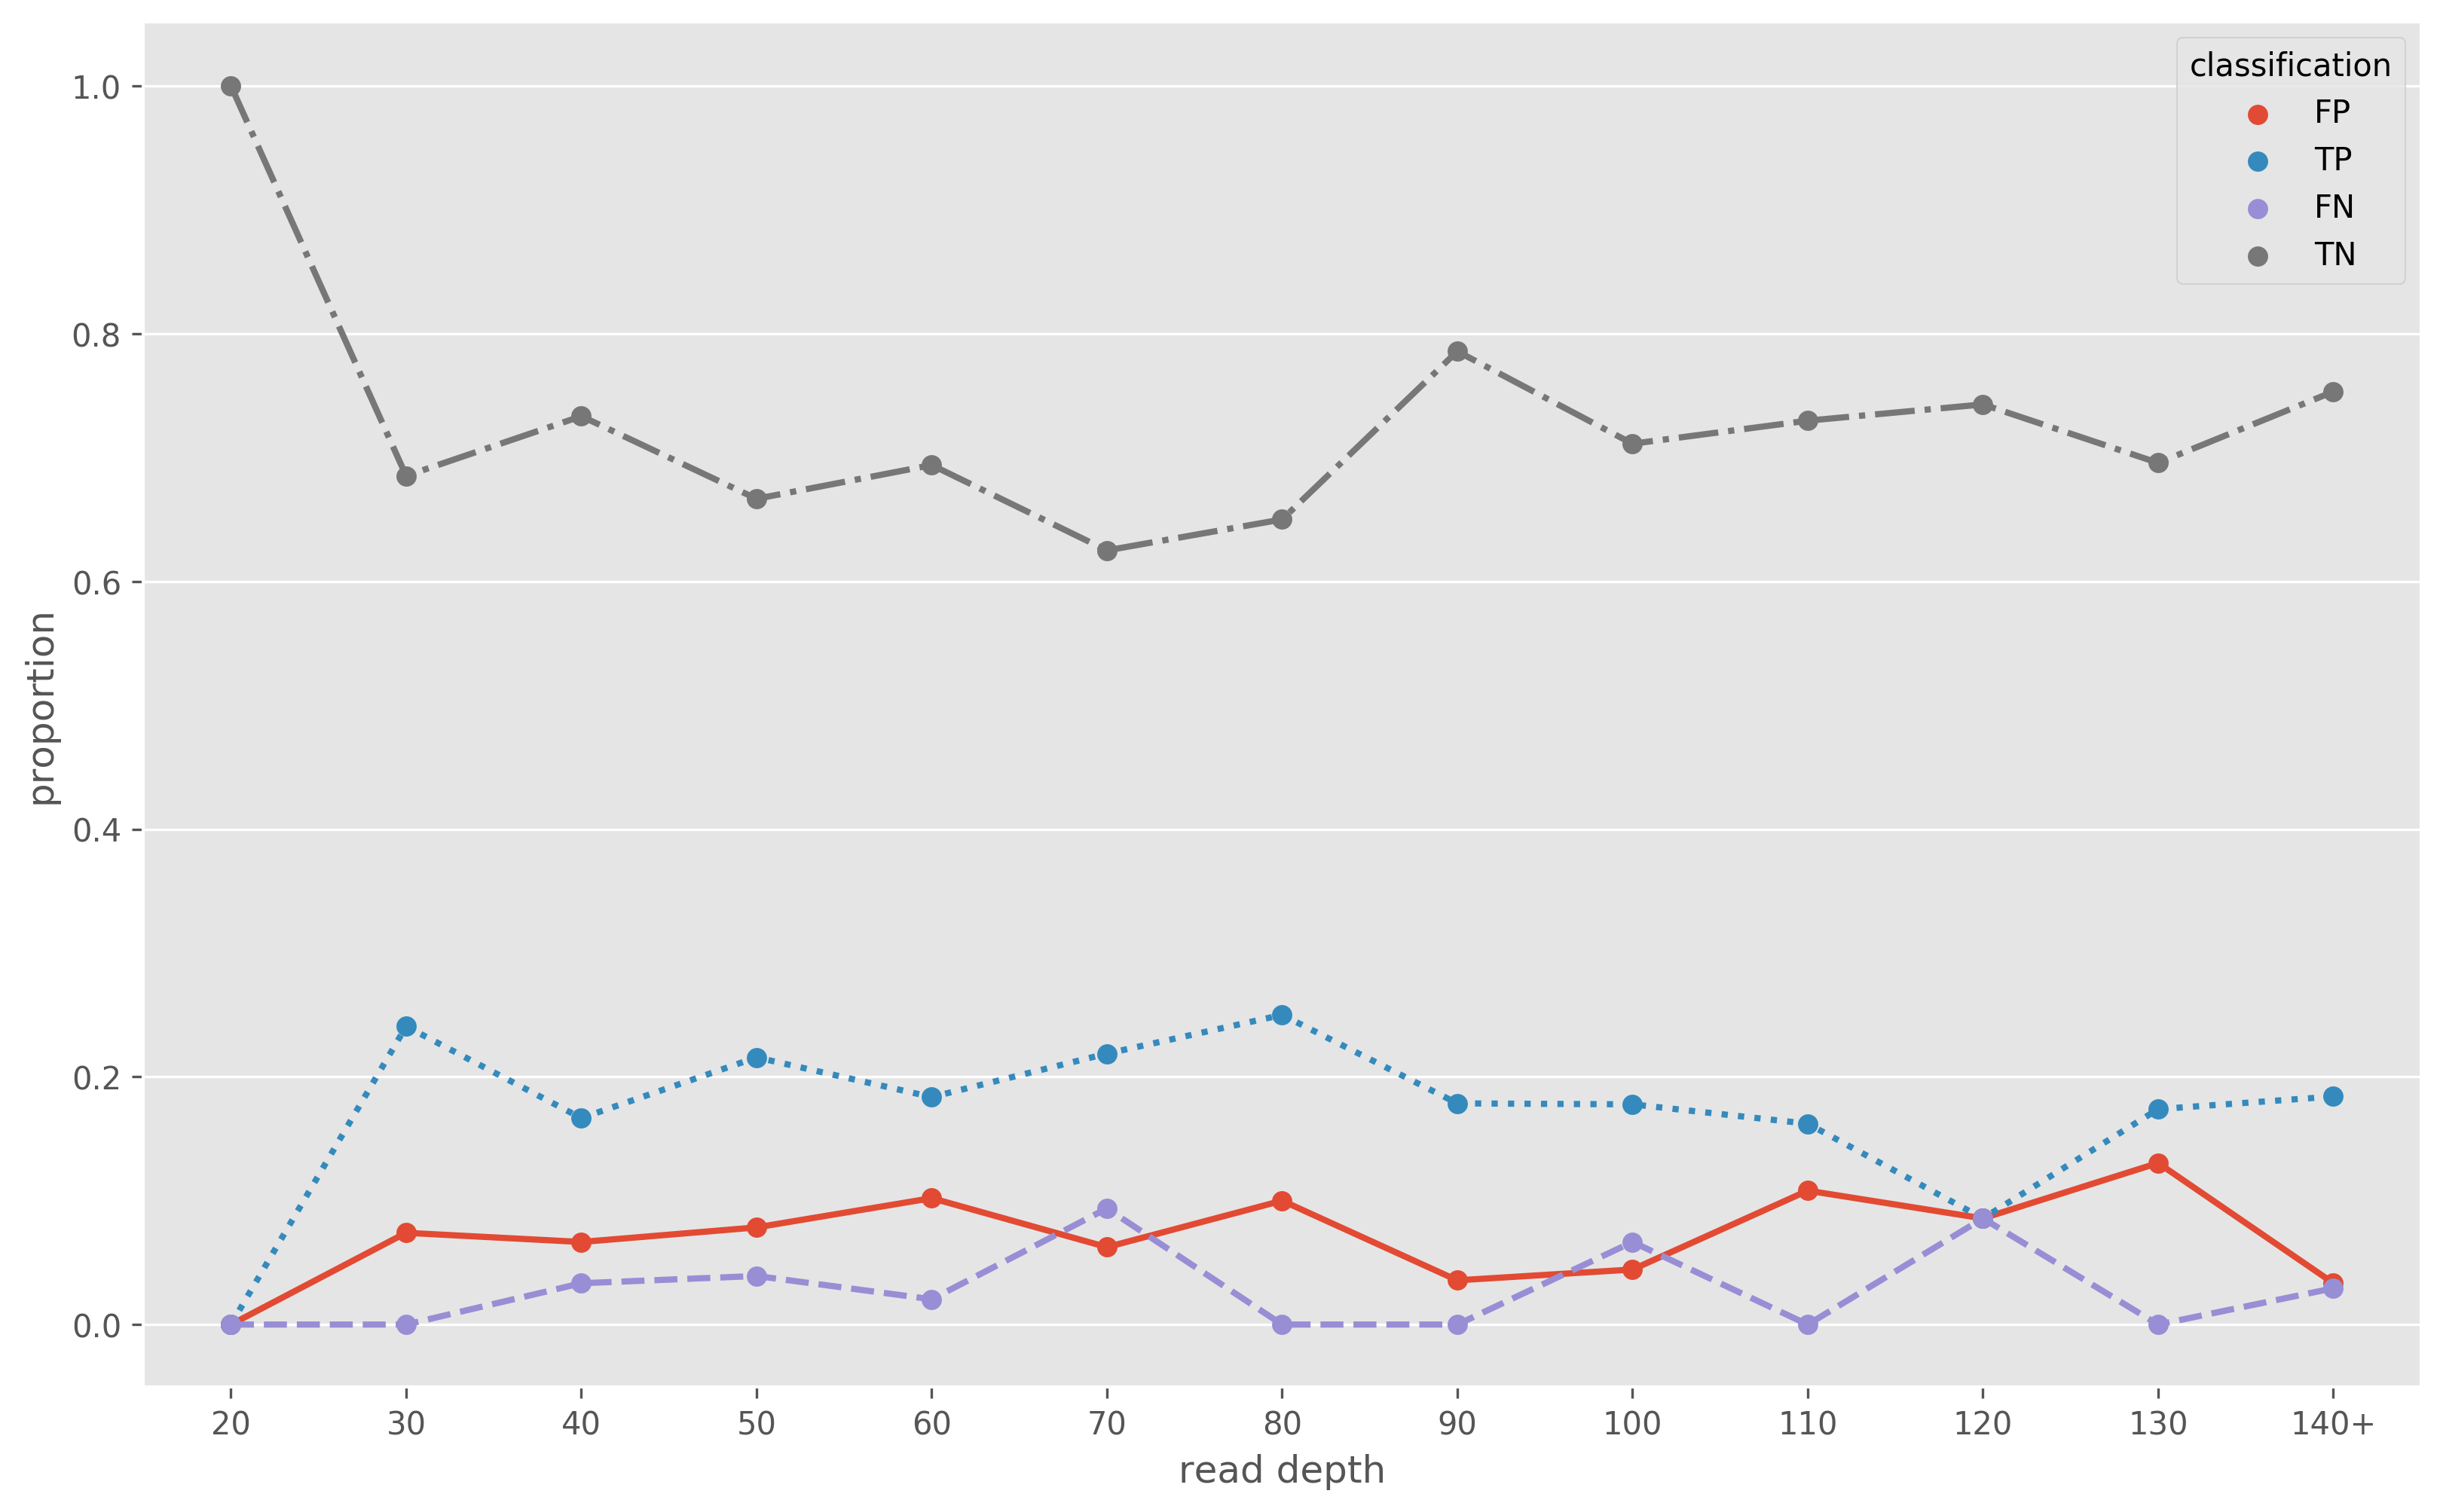

<IPython.core.display.Javascript object>

In [144]:
with sns.plotting_context(rc={"lines.linewidth": 1.1}):
    fig, ax = plt.subplots(nrows=1, figsize=(13, 8), dpi=300)
    x = "coverage"
    y = "proportion"
    hue = "classification"
    tech = "nanopore"
    linestyles = ["solid", "dotted", "dashed", "dashdot"]
    sns.pointplot(
        data=summary.query("technology == @tech"),
        x=x,
        y=y,
        hue=hue,
        ax=ax,
        linestyles=linestyles,
        alpha=0.8,
    )
    xlabels = ax.get_xticklabels()
    xlabels[-1].set_text(xlabels[-1].get_text() + "+")
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("read depth")

# Concordance of mykrobe Nanopore resistance prediction with Illumina
Having proven mykrobe's ability to predict resistance for select drugs with ONT, we look at the concordance of ONT-based predictions with Illumina-based ones. We aim to answer to main questions here: 1) Are ONT predictions concordant with Illumina and 2) does ONT depth of coverage impact prediction capabilities and, if so, what is the coverage threshold for this impact?
We will also discuss the causes for any discrepencies and look to COMPASS/bcftools calls for adjudication if possible.

For the figure/table of this section it might suffice to just have a table like the one in Table 1. of the recent mykrobe paper with a row for each drug and columns showing TPs, FNs etc. along with VME (95% CI), ME (95% CI), PPV and NPV

In [153]:
classes = sorted(set(calls["classification"]))
drugs = sorted(set(calls["drug"]))
conf_mxs = defaultdict(dict)

for drug in drugs:
    s = calls.query("drug == @drug").value_counts(subset=["classification"])
    cm = ConfusionMatrix.from_series(s)
    conf_mxs[drug] = cm

metrics = []
for drug, cm in conf_mxs.items():
    sensitivity = cm.sensitivity()
    specificity = cm.specificity()
    ppv = cm.ppv()
    npv = cm.npv()
    metrics.append((drug, sensitivity, specificity, ppv, npv))

summary = pd.DataFrame(
    metrics, columns=["drug", "sensitivity", "specificity", "PPV", "NPV"]
).melt(id_vars=["drug"], var_name="metric")

counts = calls.groupby(["drug", "classification"])["sample"].count()
fps = [counts[d, "FP"] if (d, "FP") in counts else 0 for d in drugs]
fns = [counts[d, "FN"] if (d, "FN") in counts else 0 for d in drugs]
tns = [counts[d, "TN"] if (d, "TN") in counts else 0 for d in drugs]
tps = [counts[d, "TP"] if (d, "TP") in counts else 0 for d in drugs]
table = summary.set_index(["drug", "metric"])["value"].unstack().reset_index()
table["ME/FP"] = fps
table["VME/FN"] = fns
table["TP"] = tps
table["TN"] = tns
table

metric,drug,NPV,PPV,sensitivity,specificity,ME/FP,VME/FN,TP,TN
0,Amikacin,1.000000,0.857143,1.000000,0.985507,2,0,12,136
1,Capreomycin,1.000000,0.857143,1.000000,0.985507,2,0,12,136
2,Ciprofloxacin,0.992537,1.000000,0.941176,1.000000,0,1,16,133
3,Ethambutol,0.979167,1.000000,0.964286,1.000000,0,2,54,94
4,Isoniazid,1.000000,0.919540,1.000000,0.900000,7,0,80,63
5,Kanamycin,1.000000,0.866667,1.000000,0.985401,2,0,13,135
6,Moxifloxacin,0.992537,1.000000,0.941176,1.000000,0,1,16,133
7,Ofloxacin,1.000000,1.000000,1.000000,1.000000,0,0,17,133
8,Pyrazinamide,0.991667,1.000000,0.967742,1.000000,0,1,30,119
9,Rifampicin,1.000000,1.000000,1.000000,1.000000,0,0,78,72


<IPython.core.display.Javascript object>

In [ ]:
print(table.to_markdown())